In [23]:
# To make sure that you get the implementation right let us first have a look at the data structure.
# These are the four possible input pairs of (x1,x2).
x = np.array([[0,0],[0,1],[1,0],[1,1]])
# These are possible labels form some logical gates.
t_and = np.array([0,0,0,1])
t_or = np.array([0,1,1,1])
t_nand = np.array([1,1,1,0])
t_nor = np.array([1,0,0,0])
t_xor = np.array([0,1,1,0])

In [24]:
import numpy as np

# Activation function σ.
# We use scipy's builtin because it fixes some NaN problems for us.
# sigmoid = lambda x: 1 / (1 + np.exp(-x))
def sigmoid(x):
    return (1/(1 + np.exp(-x)))

def sigmoidprime(x):
    return sigmoid(x) * (1 - sigmoid(x))

class Perceptron:
    """Single neuron handling its own weights and bias."""

    def __init__(self, dim_in, act_func=sigmoid):
        """Initialize a new neuron with its weights and bias.

        Args:
            dim_in (int): Dimensionality of the data coming into this perceptron. 
                In a network of perceptrons this basically represents the 
                number of neurons in the layer before this neuron's layer. 
                Used for generating the perceptron's weights vector, which 
                not only includes one weight per input but also an additional 
                bias weight.
            act_fun (function): Function to apply on activation.
        """
        self.act_func = act_func
        # Set self.weights
        self.weights = np.random.rand(dim_in + 1)

    def activate(self, x):
        """Activate this neuron with a specific input.

        Calculate the weighted sum of inputs and apply the activation function.

        Args:
            x (ndarray): Vector of input values.

        Returns:
            float: A real number representing the perceptron's activation after 
            calculating the weighted sum of inputs and applying the 
            perceptron's activation function.
        """
        # Return the activation value
        x = np.insert(x, 0, 1)
        return self.act_func(np.sum(self.weights * x))

    def adapt(self, x, delta, rate=0.03):
        """Adapt this neuron's weights by a specific delta.

        Args:
            x (ndarray): Vector of input values.
            delta (float): Weight adaptation delta value.
            rate (float): Learning rate.
        """
        # Adapt self.weights according to the update rule
        x = np.insert(x, 0, 1)
        self.weights += x * rate * delta


In [25]:
class PerceptronLayer:
    """Layer of multiple neurons.
    
    Attributes:
        perceptrons (list): List of perceptron instances in the layer.
    """
    def __init__(self, dim_in, dim_out, act_func=sigmoid):
        """Initialize the layer as a list of individual neurons.

        A layer contains as many neurons as it has outputs, each
        neuron has as many input weights (+ bias) as the layer has inputs.

        Args:
            dim_in (int): Dimensionality of the expected input values,
                also the size of the previous layer of a neural network.
            dim_out (int): Dimensionality of the output, also the requested 
                amount of in this layer and the input dimension of the
                next layer.
            act_func (function): Activation function to use in each perceptron of
                this layer.
        """
        # Set self.perceptrons to a list of Perceptrons
        self.perceptrons = []
        for i in range(dim_out):
            self.perceptrons.append(Perceptron(dim_in, act_func))

    def activate(self, x):
        """Activate this layer by activating each individual neuron.

        Args:
            x (ndarray): Vector of input values.

        Retuns:
            ndarray: Vector of output values which can be 
            used as input to another PerceptronLayer instance.
        """
        # return the vector of activation values
        output = []
        for node in self.perceptrons:
            output.append(node.activate(x))
            
        return np.array(output)
    
    def adapt(self, x, deltas, rate=0.03):
        """Adapt this layer by adapting each individual neuron.

        Args:
            x (ndarray): Vector of input values.
            deltas (ndarray): Vector of delta values.
            rate (float): Learning rate.
        """
        # Update all the perceptrons in this layer
        for idx, node in enumerate(self.perceptrons):
            node.adapt(x, deltas[idx], rate)
        
    @property
    def weight_matrix(self):
        """Helper property for getting this layer's weight matrix.

        Returns:
            ndarray: All the weights for this perceptron layer.
        """
        return np.asarray([p.weights for p in self.perceptrons]).T


In [90]:
class MultilayerPerceptron:
    """Network of perceptrons, also a set of multiple perceptron layers.
    
    Attributes:
        layers (list): List of perceptron layers in the network.
    """
    def __init__(self, *layers):
        """Initialize a new network, madeup of individual PerceptronLayers.

        Args:
            *layers: Arbitrarily many PerceptronLayer instances.
        """
        self.layers = layers

    def activate(self, x):
        """Activate network and return the last layer's output.

        Args:
            x (ndarray): Vector of input values.

        Returns:
            (ndarray): Vector of output values from the last layer of the 
            network after propagating forward through the network.
        """
        # Propagate activation through the network
        # and return output for last layer
        activations = [x]
        for layer in self.layers:
            activations.append(layer.activate(activations[-1]))

        return int(activations[-1] >= 0.5)
    
    def adapt(self, x, t, rate=0.1):
        """Adapt the whole network given an input and expected output.

        Args:
            x (ndarray): Vector of input values.
            t (ndarray): Vector of target values (expected outputs).
            rate (float): Learning rate.
        """
        # Activate each layer and collect intermediate outputs.
        activations = [x]
        for layer in self.layers:
            activations.append(layer.activate(activations[-1]))

        e = t - int(activations[-1] >= 0.5)
        deltas = [activations[-1] * (1 - activations[-1]) * e]
        
        for index in range(len(self.layers) - 2, -1, -1):
            delta_k = []
            for idx, neuron in enumerate(self.layers[index].perceptrons):
                e = np.sum(self.layers[index + 1].weight_matrix[idx + 1] * deltas[-1])
                delta_k.append(activations[index + 1][idx] * (1 - activations[index + 1][idx]) * e)
                
            deltas.append(np.array(delta_k))
            
        adapt_deltas = deltas[::-1]
        for index, layer in enumerate(self.layers):
            layer.adapt(activations[index], adapt_deltas[index], rate)

In [91]:
# Training
mlp = MultilayerPerceptron(
    PerceptronLayer(2, 4),
    PerceptronLayer(4, 1)
)

steps = []
accuracies = []
loss = []
target = t_xor
for i in range(5000):
    steps.append(i)
    for index in range(len(target)):
        # get the data and label
        sample = x[index]
        label = target[index]
        # perform a training step
        mlp.adapt(sample, label)
    
    accuracy_sum = 0
    epoch_loss = 0
    for k in range(len(x)):
        output = mlp.activate(x[k]) # feed each input to the perceptron (only foward step!)
        accuracy_sum += int(output == target[k])  # this turns true if the perceptron gave the right output --> then adds 1
        epoch_loss += (target[k] - output) ** 2
    loss.append(epoch_loss/len(x))
    accuracy = accuracy_sum / 4                  # we divide through all the training examples
    accuracies.append(accuracy)

In [92]:
for n in range(len(x)):
  output = int(mlp.activate(x[n]) >= 0.5)
  print("Input: %s \t True Label: %d \t Perceptron's Prediction: %d" % (np.array2string(x[n]), target[n], output))

Input: [0 0] 	 True Label: 0 	 Perceptron's Prediction: 0
Input: [0 1] 	 True Label: 1 	 Perceptron's Prediction: 1
Input: [1 0] 	 True Label: 1 	 Perceptron's Prediction: 1
Input: [1 1] 	 True Label: 0 	 Perceptron's Prediction: 0


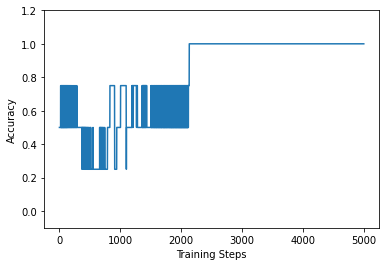

In [93]:
# Lastly let's plot the training progress.
import matplotlib.pyplot as plt
plt.figure()
plt.plot(steps, accuracies)
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.ylim([-0.1, 1.2])
plt.show()

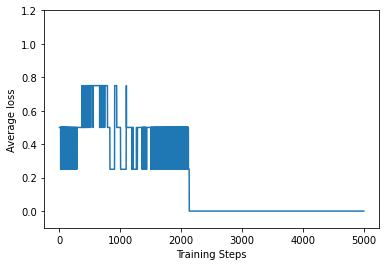

In [94]:
# Lastly let's plot the training progress.
plt.figure()
plt.plot(steps, loss)
plt.xlabel("Training Steps")
plt.ylabel("Average loss")
plt.ylim([-0.1, 1.2])
plt.show()

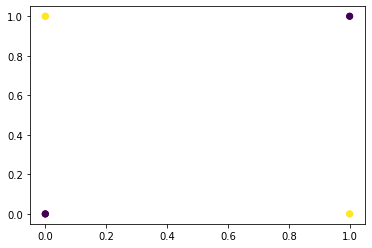

In [95]:
test = np.random.randint(0,2,(10,3))
for i in range(0, test[:,0].size):
    #test[i,2] = mlp.activate(test[i,0:1])
    output = int(mlp.activate(test[i,0:2]) >= 0.5)
    test[i,2] = output
    #print(f"row {i} data: {test[i,0:2]}")

plt.scatter(test[:,1],test[:,0], c = test[:,2])

[[0.1748658  0.50926094 0.        ]
 [0.94022608 0.84514695 0.        ]
 [0.46814194 0.9753107  0.        ]
 ...
 [0.2153184  0.83206438 0.        ]
 [0.87083108 0.64454361 0.        ]
 [0.52230667 0.07700133 0.        ]]
[0.94022608 0.84514695]


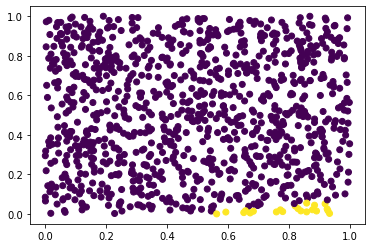

In [96]:
test_data = np.random.rand(1000, 3)
for i in range(len(test_data)):
    output = int(mlp.activate(test_data[i,0:2]) >= 0.5)
    test_data[i,2] = output
plt.scatter(test_data[:,1],test_data[:,0], c = test_data[:,2])
print(test_data)
print(test_data[1,0:2])